In [101]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [102]:
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)

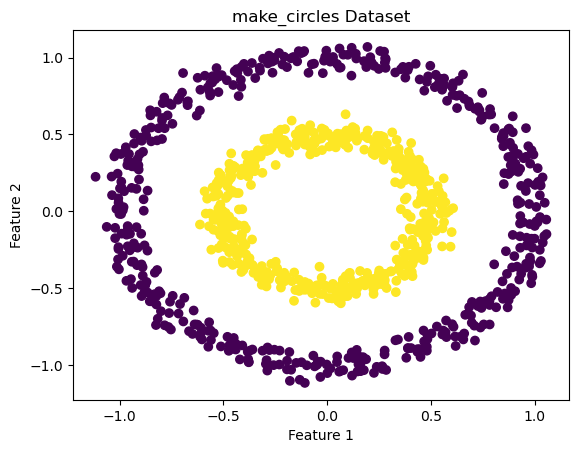

In [103]:
# Plot the generated data
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis')
plt.title("make_circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [104]:
moon_df = pd.DataFrame({"X": X_circles[:,0],"Y":  X_circles[:,1],"label": y_circles })
moon_df

,X,Y,label
0,0.452592,0.168433,1
1,-0.438027,0.119900,1
2,-0.532224,0.184359,1
3,-0.301402,0.400782,1
4,0.445602,-0.894936,0
...,...,...,...
995,0.249091,0.925787,0
996,-0.985370,-0.288162,0
997,-0.072016,-0.531447,1
998,0.660905,-0.793190,0


In [105]:
torch.__version__

'2.6.0+cpu'

In [106]:
X = torch.from_numpy(X_circles).type(torch.float)
y = torch.from_numpy(y_circles).type(torch.float)

In [107]:
# train_test_split of the data
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [108]:
print(f""" 
      input Values: {X_train[:5]}
      output_label: {y_train[:5]}
      
      """)

 
      input Values: tensor([[ 0.4413, -0.2603],
        [ 0.6030, -0.7328],
        [-1.0219, -0.1066],
        [-0.9613, -0.2265],
        [-0.1010,  0.5180]])
      output_label: tensor([1., 0., 0., 0., 1.])
      
      


In [109]:
len(X_train),len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [110]:
type(X_train),X_train.dtype, X_train.device, X_train.requires_grad

(torch.Tensor, torch.float32, device(type='cpu'), False)

In [111]:
# building model 
device = "cuda" if torch.cuda.is_available() else "cpu"


class NeuralNetworkClassification(nn.Module):
    """docstring for ."""
    def __init__(self):
        super().__init__()
        # define all the layers of the models
        self.linear1 = nn.Linear(in_features=2, out_features=10)
        self.linear2 = nn.Linear(in_features= 10, out_features= 1)
        self.sigmoid = nn.Sigmoid()
        self.relu= nn.ReLU()
        
        # using sequentail method
        # self.sequential_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self,x):
        x = self.linear1(x)
        x= self.linear2(x)
        # we used nn.BCEWithLogitsLoss (which is the combination of Sigmoid and BCELoss) so we don't need to sigmoid here
        # output = self.sigmoid(x)
        return x  
        
        # sequentail method 
        # return self.sequential_layer(x)

    

In [112]:
model = NeuralNetworkClassification().to(device)
model

NeuralNetworkClassification(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [113]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.3691,  0.3716],
                      [ 0.2644, -0.1243],
                      [-0.1872,  0.0756],
                      [-0.1249, -0.2107],
                      [ 0.4520,  0.6077],
                      [-0.0700, -0.1583],
                      [ 0.0103, -0.0422],
                      [ 0.1700,  0.1982],
                      [-0.6422, -0.2609],
                      [ 0.5955,  0.2755]])),
             ('linear1.bias',
              tensor([-0.0352, -0.4263, -0.4326, -0.6334, -0.2305,  0.2388,  0.4509,  0.3265,
                      -0.6250, -0.4252])),
             ('linear2.weight',
              tensor([[-0.0499,  0.3059,  0.0457, -0.0819,  0.1308, -0.1204, -0.2047,  0.2308,
                       -0.1438, -0.0634]])),
             ('linear2.bias', tensor([-0.3146]))])

In [114]:
# loss and optimizer for the classification problem
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters())

In [115]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)[:5]

y_logits

tensor([[-0.3615],
        [-0.2288],
        [-0.4870],
        [-0.2921],
        [-0.3936]])

In [116]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [117]:
y_pred_test= torch.round(torch.sigmoid(y_logits))
y_pred_test.squeeze()

tensor([0., 0., 0., 0., 0.])

### Training and Testing loop 

In [118]:
def accuracy(y_pred, y_true):
    # TP + FP/ TP+FP +FN + FP
   return ((torch.eq(y_pred,y_true).sum())/len(y_true)) *100

In [119]:
# putting the data into device according 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_test.device)

cpu


In [120]:
# training and testing loop 
torch.manual_seed(42)
epochs = 300

for epoch in range(epochs):
    model.train()
    
    # forward pass 
    y_logits = model(X_train).squeeze() # this are the logits without pass it from the activation function we have used the BCEWithLogits
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. calculate the loss and Accuracy of the model
    loss = loss_fn(y_logits,y_train) # we are using BCEWithLogitsLoss expects raw logits as input
    
    acc = accuracy(y_pred , y_train)
    
    
    # backpropagation 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing loop 
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test)
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        
        test_acc = accuracy(y_test_pred , y_test)
        
        
    if epoch % 10 == 0:
            print(f"Epoch: {epoch} Loss: {loss:.5f} accuracy: {acc:.2f} |  Test loss: {test_loss:.5f} Test Accuracy: {test_acc:.2f} ")
    
    
    
    

Epoch: 0 Loss: 0.71183 accuracy: 50.00 |  Test loss: 0.71704 Test Accuracy: 50.00 
Epoch: 10 Loss: 0.71157 accuracy: 50.00 |  Test loss: 0.71679 Test Accuracy: 50.00 
Epoch: 20 Loss: 0.71132 accuracy: 50.00 |  Test loss: 0.71655 Test Accuracy: 50.00 
Epoch: 30 Loss: 0.71108 accuracy: 50.00 |  Test loss: 0.71630 Test Accuracy: 50.00 
Epoch: 40 Loss: 0.71083 accuracy: 50.00 |  Test loss: 0.71606 Test Accuracy: 50.00 
Epoch: 50 Loss: 0.71059 accuracy: 50.00 |  Test loss: 0.71583 Test Accuracy: 50.00 
Epoch: 60 Loss: 0.71036 accuracy: 50.00 |  Test loss: 0.71560 Test Accuracy: 50.00 
Epoch: 70 Loss: 0.71013 accuracy: 50.00 |  Test loss: 0.71537 Test Accuracy: 50.00 
Epoch: 80 Loss: 0.70990 accuracy: 50.00 |  Test loss: 0.71514 Test Accuracy: 50.00 
Epoch: 90 Loss: 0.70967 accuracy: 50.00 |  Test loss: 0.71492 Test Accuracy: 50.00 
Epoch: 100 Loss: 0.70945 accuracy: 50.00 |  Test loss: 0.71470 Test Accuracy: 50.00 
Epoch: 110 Loss: 0.70923 accuracy: 50.00 |  Test loss: 0.71448 Test Accuracy

In [121]:
from helper_function import plot_decision_boundary

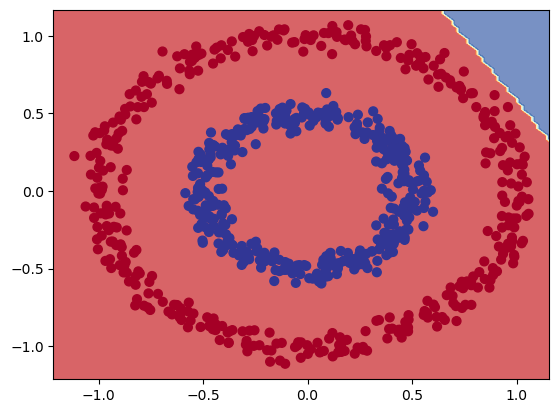

In [122]:
plot_decision_boundary(model,X_train,y_train)

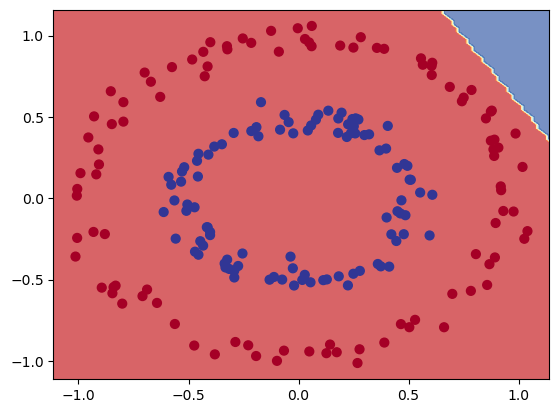

In [123]:
plot_decision_boundary(model,X_test,y_test)

In [124]:
# building model 
device = "cuda" if torch.cuda.is_available() else "cpu"


class NeuralNetworkClassification2(nn.Module):
    """docstring for ."""
    def __init__(self):
        super().__init__()
        # define all the layers of the models
        self.sequential = nn.Sequential( 
                                        nn.Linear(in_features=2, out_features=10),
                                        nn.ReLU(),
                                        nn.Linear(in_features=10, out_features=10),
                                        nn.ReLU(),
                                        # nn.Dropout(p=0.5),
                                        nn.Linear(in_features=10, out_features=1),
                                        )
     
        
        # using sequentail method
        # self.sequential_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self,x):
        
        # we used nn.BCEWithLogitsLoss (which is the combination of Sigmoid and BCELoss) so we don't need to sigmoid here
        # output = self.sigmoid(x)
        return self.sequential(x) 
        
        # sequentail method 
        # return self.sequential_layer(x)

    

In [125]:
model2 = NeuralNetworkClassification2()


In [126]:
# loss and optimizer for the classification problem
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model2.parameters(),lr=0.1)

In [ ]:
# training and testing loop 
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model2.train()
    
    # forward pass 
    y_logits = model2(X_train).squeeze() # this are the logits without pass it from the activation function we have used the BCEWithLogits
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. calculate the loss and Accuracy of the model
    loss = loss_fn(y_logits,y_train) # we are using BCEWithLogitsLoss expects raw logits as input
    
    acc = accuracy(y_pred , y_train)
    
    
    # backpropagation 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing loop 
    
    model2.eval()
    with torch.inference_mode():
        y_test_logits = model2(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test)
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        
        test_acc = accuracy(y_test_pred , y_test)
        
        
    if epoch % 100 == 0:
            print(f"Epoch: {epoch} Loss: {loss:.5f} accuracy: {acc:.2f} |  Test loss: {test_loss:.5f} Test Accuracy: {test_acc:.2f} ")
    
    
    
    

Epoch: 0 Loss: 0.69355 accuracy: 50.00 |  Test loss: 0.69369 Test Accuracy: 50.00 
Epoch: 100 Loss: 0.68407 accuracy: 62.63 |  Test loss: 0.68381 Test Accuracy: 62.50 
Epoch: 200 Loss: 0.66352 accuracy: 67.12 |  Test loss: 0.66286 Test Accuracy: 69.00 
Epoch: 300 Loss: 0.61055 accuracy: 79.00 |  Test loss: 0.60784 Test Accuracy: 78.00 
Epoch: 400 Loss: 0.49171 accuracy: 88.62 |  Test loss: 0.48806 Test Accuracy: 90.50 
Epoch: 500 Loss: 0.26501 accuracy: 99.25 |  Test loss: 0.27231 Test Accuracy: 98.50 
Epoch: 600 Loss: 0.11323 accuracy: 100.00 |  Test loss: 0.12594 Test Accuracy: 100.00 
Epoch: 700 Loss: 0.05776 accuracy: 100.00 |  Test loss: 0.06913 Test Accuracy: 100.00 


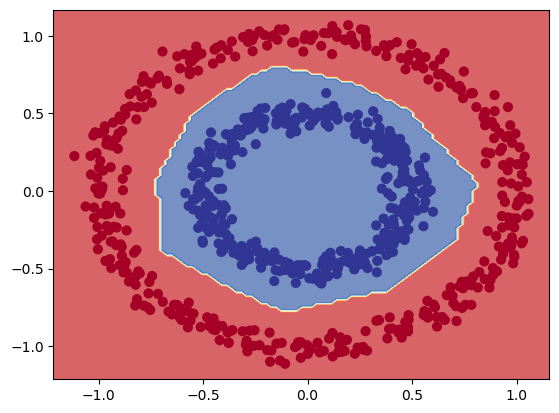

In [ ]:
plot_decision_boundary(model2,X_train,y_train)

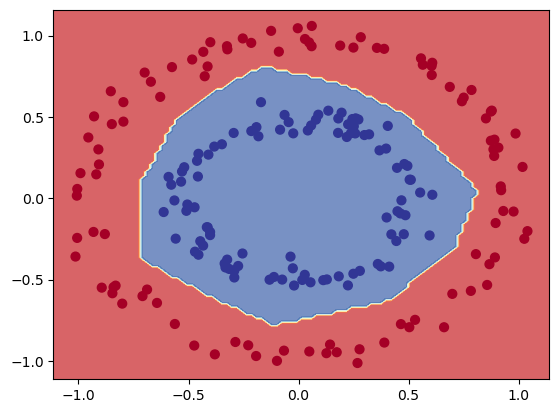

In [ ]:
plot_decision_boundary(model2,X_test,y_test)

### Multi-class Classification

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_function import plot_predictions


torch.__version__


'2.6.0+cpu'

In [ ]:
X, y = make_blobs(n_samples=1000, centers=4, n_features=2,
                random_state=42)

X = torch.from_numpy(X).to(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.dtype,y.dtype

(torch.float32, torch.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# plot_predictions(X_train,y_train,X_test,y_test)
len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

In [ ]:
len(X),len(y)

(1000, 1000)

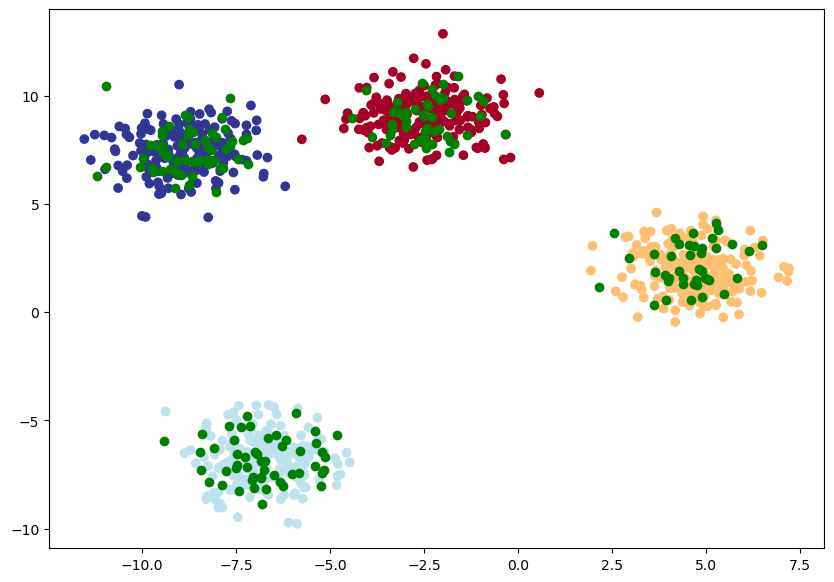

In [ ]:
# plot_predictions(X_train[:,0],X_train[:,1],X_test[:,0],X_test[:,1])

plt.figure(figsize=(10,7))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap=plt.cm.RdYlBu)

plt.scatter(X_test[:,0],X_test[:,1],c="g")
plt.show()


In [ ]:
# now we have to create a multiClass Classification model for this dataset

class MultiClassClassification(nn.Module):
    """docstring for MultiClassClassification."""
    def __init__(self):
        super(MultiClassClassification, self).__init__()
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer_3 = nn.Linear(in_features=10, out_features=4)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        return self.linear_layer_3(self.relu(self.linear_layer_2(self.relu(self.linear_layer_1(x)))))

    

In [ ]:
model_3 = MultiClassClassification().to(device)
model_3.state_dict()

OrderedDict([('linear_layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  

In [ ]:
# loss/ optimization function 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.01)

In [ ]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [ ]:
# model_3.eval()
# with torch.inference_mode():
#  y_pred = model_3(X_test)
#  y_pred_prob = torch.softmax(y_pred,dim=1)
#  y_pred_prob = torch.argmax(y_pred_prob,dim=1)



In [ ]:
# training and test loop 
epochs = 100

for epoch in range(epochs):
    model_3.train() # model in train mood which will activate dropout and batchnorm layer advantage to model during training
    # logits are raw output of the model
    
    # forward pass
    y_pred_logits = model_3(X_train)
    y_pred_label = torch.argmax(torch.softmax(y_pred_logits,dim=1),dim=1)
    
    loss = loss_fn(y_pred_logits, y_train.type(torch.long))
    acc = accuracy(y_pred_label , y_train)
    
    
    # backpropagation
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing 
    model_3.eval()
    with torch.inference_mode():
        y_test_logits = model_3(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test.to(torch.long))
        y_test_pred = torch.argmax( torch.softmax(y_test_logits,dim=1),dim=1)
        
        # torch.softmax().argmax(dim=1 )
        
        test_acc = accuracy(y_test_pred , y_test)
        
    
    
    if epoch % 10 == 0:
        
        print(f"Epoch: {epoch} loss:{loss:.5f} accuracy: {acc}%  test loss: {test_loss:.5f} test_accuracy: {test_acc}% ")
    
    


Epoch: 0 loss:0.30231 accuracy: 99.75%  test loss: 0.31936 test_accuracy: 100.0% 
Epoch: 10 loss:0.28772 accuracy: 99.875%  test loss: 0.30381 test_accuracy: 100.0% 
Epoch: 20 loss:0.27287 accuracy: 99.875%  test loss: 0.28797 test_accuracy: 100.0% 
Epoch: 30 loss:0.25772 accuracy: 99.875%  test loss: 0.27178 test_accuracy: 100.0% 
Epoch: 40 loss:0.24228 accuracy: 99.875%  test loss: 0.25528 test_accuracy: 100.0% 
Epoch: 50 loss:0.22660 accuracy: 99.875%  test loss: 0.23856 test_accuracy: 100.0% 
Epoch: 60 loss:0.21086 accuracy: 99.875%  test loss: 0.22176 test_accuracy: 100.0% 
Epoch: 70 loss:0.19524 accuracy: 99.875%  test loss: 0.20510 test_accuracy: 100.0% 
Epoch: 80 loss:0.17995 accuracy: 99.875%  test loss: 0.18882 test_accuracy: 100.0% 
Epoch: 90 loss:0.16520 accuracy: 99.875%  test loss: 0.17312 test_accuracy: 100.0% 


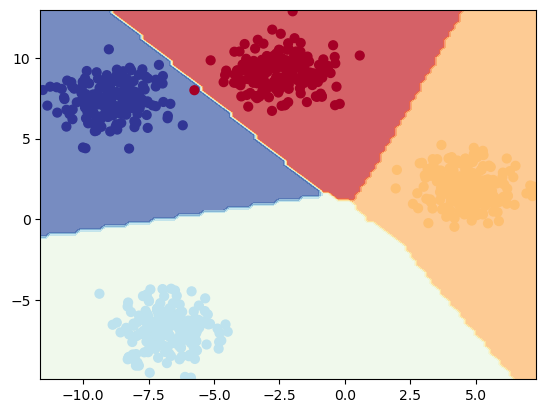

In [ ]:


plot_decision_boundary(model_3,X_train,y_train)

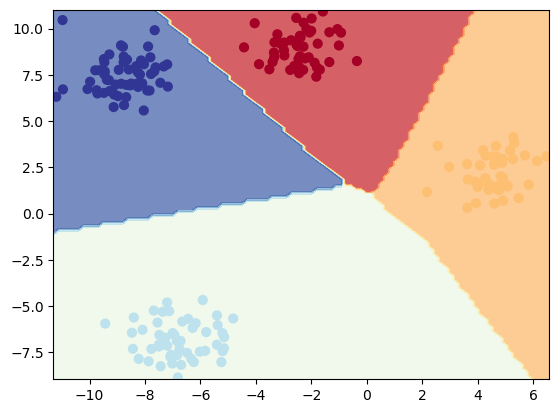

In [ ]:

plot_decision_boundary(model_3,X_test,y_test)